# FastAI models.validate CUDA Tensor Issue

WNixalo – 2018/6/11

---

I ran into trouble trying to reimplement a CIFAR-10 baseline notebook. The notebook used PyTorch dataloaders fed into a ModelData object constructor. The issue occurred when running the learning rate finder: at the end of its run a `TypeError` would be thrown. This error came from attempting to compare `preds.data` and `y` inside of the `metrics.accuracy` function which was called in `model.validate` by the line:
```
res.append([f(preds.data, y) for f in metrics])
```

where `metrics` is `[accuracy]`.

On an AWS p2.xlarge (and I assume any GPU) machine, this results in comparing a `torch.cuda.FloatTensor` (`preds.data`) to a `torch.LongTensor` (`y`), throwing an error.

This error *did not* occur when using an older version of the fast.ai library, [available here](https://github.com/radekosmulski/fastai/releases/tag/v0.61-dawnbench).

The reason is that within `model.validate(.)`, `y = VV(y)`, and `y.data` is passed into the accuracy metric function. This is the proposed fix.

To make sure that recasting a Variable to Variable via `VV(.)` won't break anything (eg: if a fast.ai dataloader is used, returning .cuda. tensors:

In [1]:
import torch
from fastai.conv_learner import *

In [20]:
x = torch.FloatTensor([[[1,1,],[1,1]]]); x


(0 ,.,.) = 
  1  1
  1  1
[torch.FloatTensor of size 1x2x2]

In [21]:
VV(x)

Variable containing:
(0 ,.,.) = 
  1  1
  1  1
[torch.FloatTensor of size 1x2x2]

In [22]:
VV(VV(x))

Variable containing:
(0 ,.,.) = 
  1  1
  1  1
[torch.FloatTensor of size 1x2x2]

In [27]:
torch.equal(VV(x), VV(VV(x)))

True

None of this is an issue if constructing a fast.ai Model Data object via it's constructors (eg: `md = ImageClassifierData.from_csv(...)`) because fast.ai uses it's own dataloaders which automatically place data on the GPU if in use via `dataloader.get_tensor(.)`. The issue arises when PyTorch dataloaders are used, but all low-level details (calculating loss, metrics, etc) are handled internally by the fast.ai library.

This notebook shows a demo workflow: triggering the issue, demonstrating the fix, and showing a mini debug walkthrough.

For  more detailed troubleshooting notes, see the accompanying debugging_notes.txt.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import cifar_utils

from fastai.conv_learner import *
from torchvision import transforms, datasets

torch.backends.cudnn.benchmark = True

**Note**: the [fastai/imagenet-fast](https://github.com/fastai/imagenet-fast) repository was cloned, with a symlink `imagenet_fast_cifar_models` pointing to `imagenet-fast/cifar10/models/`. This is because the wide-resnet-22 from fast.ai's DAWN Bench submission was used. Any other architecture can be used without going through the trouble to import this.

In [ ]:
# fastai/imagenet-fast/cifar10/models/ repo
from imagenet_fast_cifar_models.wideresnet import wrn_22

In [2]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [3]:
def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir = str(PATH/'test')
    tfms = [transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    aug_tfms =transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(
        traindir,
        aug_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)

    val_dataset = datasets.ImageFolder(valdir, transforms.Compose(tfms))

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    aug_dataset = datasets.ImageFolder(valdir, aug_tfms)

    aug_loader = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, aug_loader

In [4]:
def get_data(bs, num_workers):
    trn_dl, val_dl, aug_dl = get_loaders(bs, num_workers)
    data = ModelData(PATH, trn_dl, val_dl)
    data.aug_dl = aug_dl
    data.sz=32
    return data

def get_learner(arch, bs):
    learn = ConvLearner.from_model_data(arch.cuda(), get_data(bs, num_cpus()))
    learn.crit = nn.CrossEntropyLoss()
    learn.metrics = [accuracy]
    return learn

def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

Using a small (10%) random subset of the dataset:

In [5]:
PATH = Path("data/cifar10_tmp")

In [7]:
# PATH = Path("data/cifar10")
# print(cifar_utils.count_files(PATH))
# PATH = cifar_utils.create_cifar_subset(PATH, copydirs=['train','test'], p=0.1)
# print(cifar_utils.count_files(PATH))

60003
6001


## 1.

With current fastai version:

In [6]:
learn = get_learner(wrn_22(), 512)
learn.lr_find(wds=1e-4)
learn.sched.plot(n_skip_end=1)

TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)


## 2.

With `models.validate` modified so that `y = VV(y)` and `y.data` is now passed to `f(.)` in `res.append(.)`:

(**note** a smaller batch size is used just so a *any* plot is displayed -- the sample dataset size is a bit too small for useful information with these settings)

epoch      trn_loss   val_loss   accuracy                 
    0      2.938193   713156276518.912 0.1       


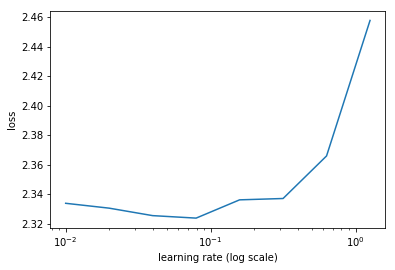

In [21]:
learn = get_learner(wrn_22(), 256)
learn.lr_find(wds=1e-4)
learn.sched.plot(n_skip_end=1)

Making sure test predictions work:

In [22]:
log_preds, _ = learn.TTA(is_test=False) # 'test' dataloader never initialized; using val

Example same as the above, but with a full-size (50,000 element) training set:

epoch      trn_loss   val_loss   accuracy                 
    0      2.301422   77005.0754 0.1       


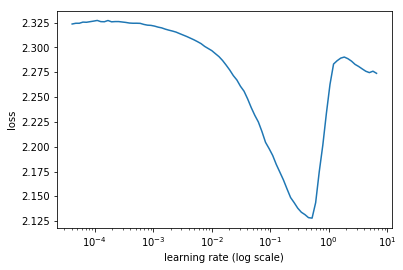

In [14]:
PATH = Path('data/cifar10')
learn = get_learner(wrn_22(), 512)
learn.lr_find(wds=1e-4)
learn.sched.plot(n_skip_end=1)

## 3.

An example debugging and showing `y` vs `VV(y)` vs `VV(y).data`.

- `accuracy(preds.data, y)` throws a `TypeError` because `preds.data` is a `torch.cuda.FloatTensor` and `y` is a `torch.LongTensor`. `y` needs to be a CUDA tensor.

- `accuracy([preds.data, VV(y))` throws another `TypeError` because `VV(y)` is a `Variable`.
- `accuracy([pred.sdata, VV(y).data)` works and returns an accuracy value, because `y` is now a `torch.cuda.LongTensor` which can be compared to the CUDA tensor `preds.data`.


In [10]:
# using the 10% sample dataset
learn = get_learner(wrn_22(), 512)
learn.lr_find(wds=1e-4)
learn.sched.plot(n_skip_end=1)

> /home/ubuntu/Kaukasos/fastai/model.py(224)validate()   
-> preds, l = stepper.evaluate(VV(x), VV(y))
(Pdb) n
> /home/ubuntu/Kaukasos/fastai/model.py(225)validate()
-> batch_cnts.append(batch_sz(x, seq_first=seq_first))
(Pdb) n
> /home/ubuntu/Kaukasos/fastai/model.py(226)validate()
-> loss.append(to_np(l))
(Pdb) n
> /home/ubuntu/Kaukasos/fastai/model.py(227)validate()
-> res.append([f(preds.data, y) for f in metrics])
(Pdb) metrics[0](preds.data, y)
*** TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: (torch.LongTensor)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: (torch.LongTensor)
(Pdb) metrics[0](preds.data, VV(y))
*** TypeError: eq received an invalid combination of arguments - got (Variable), but expected one of:
 * (int value)
      didn't match because some of the arguments have inva

BdbQuit: 